- The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

- Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist/sexist and label ‘0’ denotes the tweet is not racist/sexist, your objective is to predict the labels on the given test dataset.

# 1) Importing the important libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
%matplotlib inline

In [ ]:
pd.set_option("display.max_colwidth", 200)

# 2) Loading the dataset

In [ ]:
from google.colab import files
files.upload()

Saving test_tweets_anuFYb8.csv to test_tweets_anuFYb8.csv
Saving train_E6oV3lV.csv to train_E6oV3lV.csv


{'test_tweets_anuFYb8.csv': b'id,tweet\n31963,#studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterials\xc3\xa2\xc2\x80\xc2\xa6 \n31964, @user #white #supremacists want everyone to see the new \xc3\xa2\xc2\x80\xc2\x98  #birds\xc3\xa2\xc2\x80\xc2\x99 #movie \xc3\xa2\xc2\x80\xc2\x94 and here\xc3\xa2\xc2\x80\xc2\x99s why  \n31965,safe ways to heal your #acne!!    #altwaystoheal #healthy   #healing!! \n31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? \xc3\xb0\xc2\x9f\xc2\x98\xc2\x8d\xc3\xb0\xc2\x9f\xc2\x98\xc2\x8d\xc3\xb0\xc2\x9f\xc2\x98\xc2\x8d   #harrypotter #pottermore #favorite"\n31967,"  3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and misses\xc3\xa2\xc2\x80\xc2\xa6 "\n31968,choose to be   :) #momtips \n31969,something inside me dies \xc3\xb0\xc2\x9f\xc2\x92\xc2\xa6\xc3\xb0\xc2\x9f\xc2\x92\xc2\xbf\xc3\xa2\xc2\x9c\xc2\xa8  eyes ness #smokeyeyes #tired  #lonely #sof #grunge\xc

In [ ]:
train = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')
print(f'The shape of training dataset is :: {train.shape}')
print(f'The shape of test dataset is :: {test.shape}')

The shape of training dataset is :: (31962, 3)
The shape of test dataset is :: (17197, 2)


In [ ]:
train.head()

id  ...                                                                                                                       tweet
0   1  ...                       @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
1   2  ...  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
2   3  ...                                                                                                         bihday your majesty
3   4  ...                                      #model   i love u take with u all the time in urð±!!! ðððð
ð¦ð¦ð¦  
4   5  ...                                                                                      factsguide: society now    #motivation

[5 rows x 3 columns]

In [ ]:
test.head()

id                                                                                                                                           tweet
0  31963                                                      #studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ¦ 
1  31964                                            @user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why  
2  31965                                                                         safe ways to heal your #acne!!    #altwaystoheal #healthy   #healing!! 
3  31966  is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð   #harrypotter #pottermore #favorite
4  31967                                                     3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦

# 3) Text Description and Exploration

In [ ]:
train.describe()

id         label
count  31962.000000  31962.000000
mean   15981.500000      0.070146
std     9226.778988      0.255397
min        1.000000      0.000000
25%     7991.250000      0.000000
50%    15981.500000      0.000000
75%    23971.750000      0.000000
max    31962.000000      1.000000

In [ ]:
train.label.nunique()

2

In [ ]:
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [ ]:
train[train.label == 1].head()

id  ...                                                                                                     tweet
13  14  ...                                @user #cnn calls #michigan middle school 'build the wall' chant '' #tcot  
14  15  ...     no comment!  in #australia   #opkillingbay #seashepherd #helpcovedolphins #thecove  #helpcovedolphins
17  18  ...                                                                                    retweet if you agree! 
23  24  ...                                                           @user @user lumpy says i am a . prove it lumpy.
34  35  ...  it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia 

[5 rows x 3 columns]

In [ ]:
train[train.label == 0].head()

id  ...                                                                                                                       tweet
0   1  ...                       @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
1   2  ...  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
2   3  ...                                                                                                         bihday your majesty
3   4  ...                                      #model   i love u take with u all the time in urð±!!! ðððð
ð¦ð¦ð¦  
4   5  ...                                                                                      factsguide: society now    #motivation

[5 rows x 3 columns]

- Looking at the value counts of the labels, it can be induced that the amount of hate tweets are much higher than the non-hate tweets. And this is a case of imbalanced classification, which might lead to wrong classification.

In [ ]:
print(f'Number of missing labels = {train["label"].isnull().sum()}')
print(f'Number of missing tweets = {train["tweet"].isnull().sum()}')

Number of missing labels = 0
Number of missing tweets = 0


In [ ]:
train_len = train['tweet'].str.len()
test_len = test['tweet'].str.len()

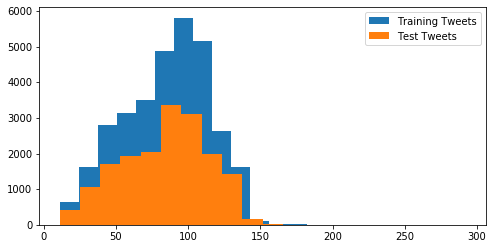

In [ ]:
plt.figure(figsize = (8,4))
plt.hist(train_len, bins = 20, label = 'Training Tweets')
plt.hist(test_len, bins = 20, label = 'Test Tweets')
plt.legend()
plt.show()

## 4) Text Pre-processing

In [ ]:
train.columns, test.columns

(Index(['id', 'label', 'tweet'], dtype='object'),
 Index(['id', 'tweet'], dtype='object'))

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

combo_set = train.append(test, ignore_index=True) 
combo_set.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(49159, 3)

In [ ]:
combo_set.dtypes

id         int64
label    float64
tweet     object
dtype: object

In [ ]:
combo_set.head()

id  ...                                                                                                                       tweet
0   1  ...                       @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
1   2  ...  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
2   3  ...                                                                                                         bihday your majesty
3   4  ...                                      #model   i love u take with u all the time in urð±!!! ðððð
ð¦ð¦ð¦  
4   5  ...                                                                                      factsguide: society now    #motivation

[5 rows x 3 columns]

In [ ]:
combo_set.tail()

id  ...                                                                                                                                              tweet
49154  49155  ...                                       thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics  #brexit #blm &gt;3 
49155  49156  ...                                                   feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid  â¦ 
49156  49157  ...  #hillary #campaigned today in #ohio((omg)) &amp; used words like "assets&amp;liability" never once did #clinton say thee(word) #radicalization   
49157  49158  ...                                           happy, at work conference: right mindset leads to culture-of-development organizations    #work #mindset
49158  49159  ...                                                                                   my   song "so glad" free download!  #shoegaze #newmusic #newsong

[5 rows x 3 columns]

## 4.1) Text Cleaning

In [ ]:
def remove_pattern(text, pattern):
    r = re.findall(pattern, text)
    for i in r:
        text = re.sub(i, '', text)
    return text

In [ ]:
## Removing Twitter Handles
combo_set['tweet_clean'] = np.vectorize(remove_pattern)(combo_set['tweet'], "@[\w]*")
combo_set.head()

id  ...                                                                                                       tweet_clean
0   1  ...                   when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
1   2  ...    thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
2   3  ...                                                                                               bihday your majesty
3   4  ...                            #model   i love u take with u all the time in urð±!!! ðððð
ð¦ð¦ð¦  
4   5  ...                                                                            factsguide: society now    #motivation

[5 rows x 4 columns]

In [ ]:
## Removing anything except alphabets and #
combo_set['tweet_clean'] = combo_set['tweet_clean'].str.replace("[^a-zA-Z#]", " ") 
combo_set.head()

id  ...                                                                                                       tweet_clean
0   1  ...                   when a father is dysfunctional and is so selfish he drags his kids into his dysfunction    #run
1   2  ...    thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx     #disapointed #getthanked
2   3  ...                                                                                               bihday your majesty
3   4  ...                            #model   i love u take with u all the time in ur                                      
4   5  ...                                                                            factsguide  society now    #motivation

[5 rows x 4 columns]

In [ ]:
combo_set['tweet_clean'] = combo_set['tweet_clean'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combo_set.head(3)

id  ...                                                                    tweet_clean
0   1  ...             when father dysfunctional selfish drags kids into dysfunction #run
1   2  ...  thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2   3  ...                                                            bihday your majesty

[3 rows x 4 columns]

In [ ]:
token_tweet = combo_set['tweet_clean'].apply(lambda x: x.split()) ## Tokenizing 
token_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tweet_clean, dtype: object

In [ ]:
import nltk

wn = nltk.WordNetLemmatizer()
dir(wn)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 'lemmatize',
 'unicode_repr']

In [ ]:
def lemmatization(twt_token):
    text = [wn.lemmatize(word) for word in twt_token]
    return text

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
combo_set['tweet_clean'] = combo_set['tweet_clean'].apply(lambda x: lemmatization(x))

for i in range(len(token_tweet)):
    token_tweet[i] = ' '.join(token_tweet[i])    
combo_set['tweet_clean'] = token_tweet

combo_set.head()

id  ...                                                                    tweet_clean
0   1  ...             when father dysfunctional selfish drags kids into dysfunction #run
1   2  ...  thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2   3  ...                                                            bihday your majesty
3   4  ...                                                     #model love take with time
4   5  ...                                                 factsguide society #motivation

[5 rows x 4 columns]

## 5) Text visualization

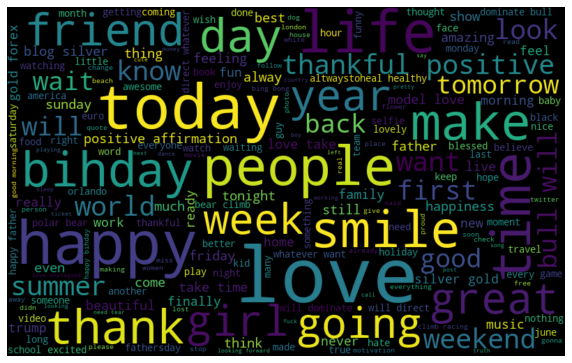

In [ ]:
all_words = ' '.join([text for text in combo_set['tweet_clean']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

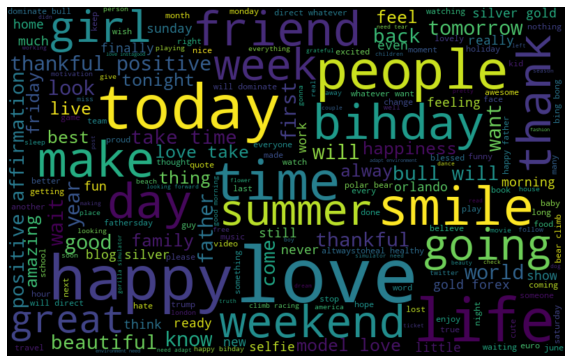

In [ ]:
#### NON-Racist words
normal_words =' '.join([text for text in combo_set['tweet_clean'][combo_set['label'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

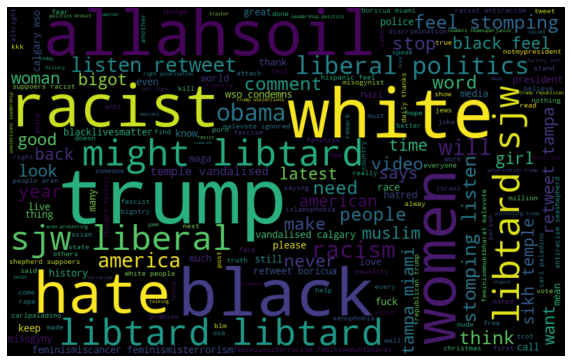

In [ ]:
#### Racist Words
normal_words =' '.join([text for text in combo_set['tweet_clean'][combo_set['label'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Hashtag Importance

In [ ]:
def hashtags(txt):
    hashtags = []
    for i in txt:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [ ]:
HT_normal = hashtags(combo_set['tweet_clean'][combo_set['label'] == 0])
HT_negative = hashtags(combo_set['tweet_clean'][combo_set['label'] == 1])

In [ ]:
print(HT_normal)
print('/n')
print(HT_negative)

[['run'], ['lyft', 'disapointed', 'getthanked'], [], ['model'], ['motivation'], ['allshowandnogo'], [], ['school', 'exams', 'hate', 'imagine', 'actorslife', 'revolutionschool', 'girl'], ['allin', 'cavs', 'champions', 'cleveland', 'clevelandcavaliers'], [], ['ireland', 'blog', 'silver', 'gold', 'forex'], ['orlando', 'standwithorlando', 'pulseshooting', 'orlandoshooting', 'biggerproblems', 'selfish', 'heabreaking', 'values', 'love'], ['gettingfed'], ['got', 'junior', 'yugyoem', 'omg'], ['thankful', 'positive'], ['friday', 'cookies'], [], ['euro'], ['badday', 'coneofshame', 'cats', 'pissed', 'funny', 'laughs'], ['wine', 'weekend'], ['tgif', 'gamedev', 'indiedev', 'indiegamedev', 'squad'], ['upsideofflorida', 'shopalyssas', 'love'], ['smiles', 'media', 'pressconference', 'antalya', 'turkey', 'throwback'], ['ica'], [], ['rip', 'orlando'], [], ['alohafriday', 'time', 'not', 'exist', 'positivevibes', 'hawaiian'], [], ['goodnight', 'badmonday'], ['taylorswift'], ['travelingram', 'dalat', 'ripi

In [ ]:
## Hashtag list needed to be unnested as that contained some list of lists
HT_normal = sum(HT_normal, [])
HT_negative = sum(HT_negative,[]) 

Normal And Negative tweets

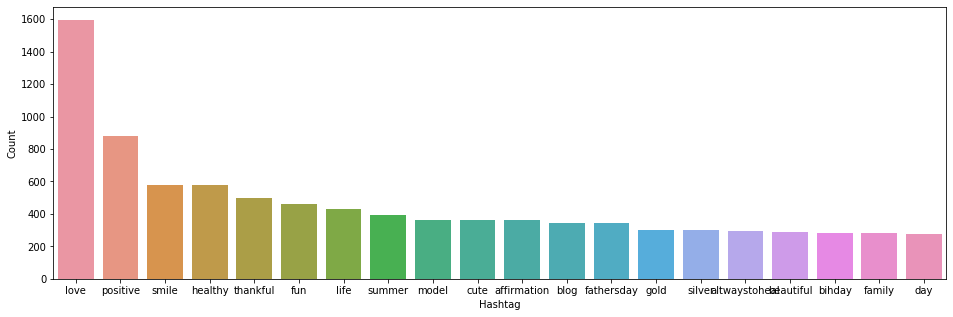

In [ ]:
## Normal Tweets

norm = nltk.FreqDist(HT_normal)
norm_data = pd.DataFrame({'Hashtag': list(norm.keys()),'Count': list(norm.values())}) 
# selecting top 20 most frequent hashtags
norm_data = norm_data.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=norm_data, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

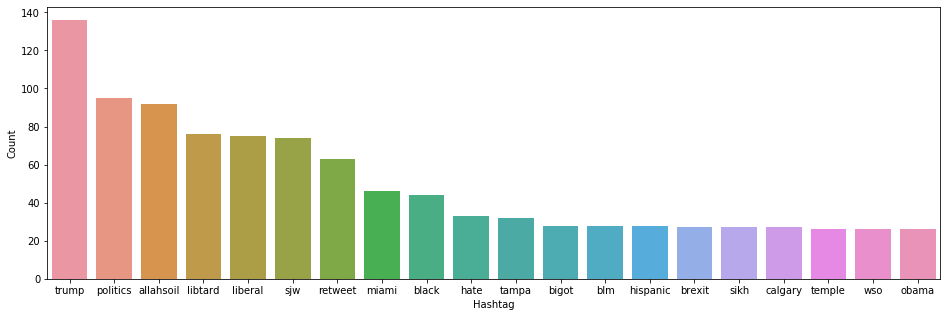

In [ ]:
## Negative tweets

neg = nltk.FreqDist(HT_negative)
neg_data = pd.DataFrame({'Hashtag': list(neg.keys()),'Count': list(neg.values())}) 
# selecting top 20 most frequent hashtags
neg_data = neg_data.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=neg_data, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

# 6) Training and Predicting

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vect.fit_transform(combo_set['tweet_clean'])

tfidf.shape

(49159, 47071)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

In [ ]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(train_tfidf, train['label'], random_state=42, test_size=0.3)
xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

### 6.1) Logistic Regression

In [ ]:
lreg = LogisticRegression()

lreg.fit(xtrain_tfidf, ytrain) 
prediction = lreg.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5450980392156862

In [ ]:
from sklearn import svm

svc = svm.SVC(kernel='linear', 
C=1, probability=True).fit(xtrain_tfidf, ytrain) 
predict_svc = svc.predict_proba(xvalid_tfidf) 
predict_int = predict_svc[:,1] >= 0.3 
predict_int = predict_int.astype(np.int) 
f1_score(yvalid, predict_int)

0.6650679456434851

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain) 
prediction = rf.predict(xvalid_tfidf)

f1_score(yvalid, prediction)

0.6202290076335878

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain) 
prediction = xgb.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.5617342130065975

In [ ]:
### Prediction of test set using SVM

test_pred = svc.predict_proba(test_tfidf)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_svc.csv', index=False)